# Code Assignment 19 — Baseline vs. ARIMA on NYC COVID-19 Daily Cases

**Dataset:** NYC DOHMH — *COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths*  
**Target Variable:** `CASE_COUNT`  
**Goal:** Create a **daily** time series, do a **chronological 80/20 split**, run **ADF on differenced time series be sure to use the TRAIN**, then implement a **Baseline model** and **two ARIMA models** and compare **RMSE**.



## Instructor Guidance (some of these steps will be done for you -- look for the "RUN CELL WITHOUT CHANGES" comment)

**Plan**
1) **Load  CSV** → normalize column names; ensure a proper datetime column.  
2) **Select target** `case_count`; coerce to numeric (strip commas).  
3) **Daily index** + **linear interpolation** (fill small gaps).  
4) **Chronological split (80/20)**: first 80% → TRAIN; last 20% → TEST.  
5) **ADF on differenced TRAIN** (provided).  
6) **Student builds**:
   - **Baseline (shift/naïve)** forecast for TEST; compute **RMSE**.  
   - **ARIMA #1**: pick `(p,d,q)`; fit on TRAIN; forecast into TEST; RMSE.  
   - **ARIMA #2**: pick a different `(p,d,q)`; repeat; RMSE.  
7) **Compare RMSEs** and reflect which model beat baseline and by how much.

**Documentation topics to lookup** 
- `statsmodels.tsa.arima.model.ARIMA`  
- `statsmodels.tsa.stattools.adfuller`  
- `sklearn.metrics.mean_squared_error`

### breakdown - What is ARIMA?

- ARIMA = AutoRegressive Integrated Moving Average. It's forecasting model that:
    - Looks at past values (AR part).
    - Uses differencing to remove trends / make data stationary (I part).
    - Uses past error patterns (MA part).
    - It's a smarter version of the baseline because it learns patterns in the data.
- You choose 3 numbers: ARIMA(p, d, q)
    1. p = how many past values influence today (lags)
    2. d = differencing (usually 1)
    3. q = how many past errors influence today

### Step 0:  Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

### Step 1:  Load CSV, Keep Needed Columns, Change time column to a datetime object

In [2]:
DATA_PATH = None

df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/covid copy.csv')

date_col = "date_of_interest"
target_col = "CASE_COUNT"

# Parse date and sort
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col)

# Keep only what we need
df = df[[date_col, target_col]].copy()

df.head()

,date_of_interest,CASE_COUNT
0,2020-02-29,1
1,2020-03-01,0
2,2020-03-02,0
3,2020-03-03,1
4,2020-03-04,5


### Step 2:  Make a daily series for CASE_COUNT (fill tiny gaps linearly)

In [4]:
s = df.set_index(date_col)[target_col].asfreq("D")

s = pd.to_numeric(s.astype(str).str.replace(",", ""))

s = s.astype("float64")
#Do a linear interpolation on the series 
s = s.interpolate(method='linear') # Fill in any missing days by drawing a straight line between the numbers we do have.

print("Range:", s.index.min().date(), "→", s.index.max().date(), "| Length:", len(s))
s.head()



Range: 2020-02-29 → 2025-10-13 | Length: 2054


date_of_interest
2020-02-29   1.000
2020-03-01   0.000
2020-03-02   0.000
2020-03-03   1.000
2020-03-04   5.000
Freq: D, Name: CASE_COUNT, dtype: float64

### Step 3: Chronological split: first 80% TRAIN, last 20% TEST

Train: 2020-02-29 → 2024-08-28 | n = 1643
Test : 2024-08-29 → 2025-10-13 | n = 411


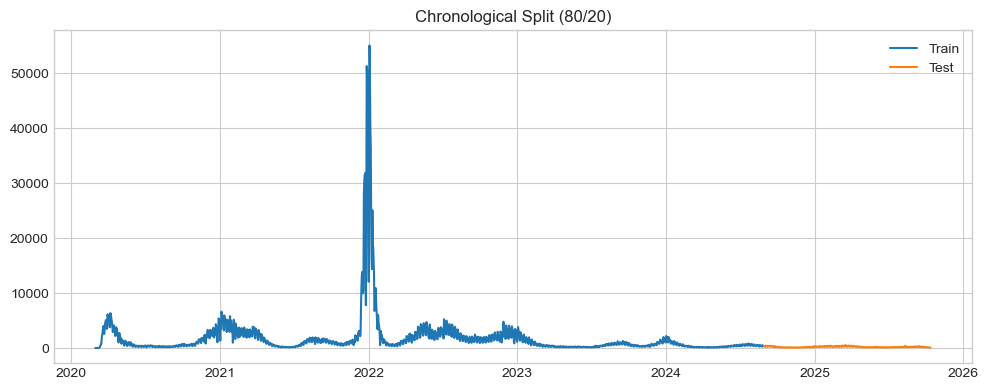

In [5]:
#RUN THIS CELL WITHOUT CHANGES 

split_idx = int(len(s) * 0.80)
train = s.iloc[:split_idx]
test  = s.iloc[split_idx:]

print("Train:", train.index.min().date(), "→", train.index.max().date(), "| n =", len(train))
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  "| n =", len(test))

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test,  label="Test", color="#ff7f0e")
plt.title("Chronological Split (80/20)")
plt.legend()
plt.tight_layout()
plt.show()

### Step 4:  ADF on DIFFERENCED TRAINING data 

In [6]:
# RUN THIS CELL WITHOUT CHANGES

diff_train = train.diff().dropna()
adf_stat, adf_p, _, _, crit, _ = adfuller(diff_train)

print(f"ADF on differenced TRAIN: stat={adf_stat:.3f}, p={adf_p:.4f}")
for k, v in crit.items():
    print(f"  critical {k}: {v:.3f}")
print("\nIf p < 0.05, using d=1 in ARIMA is reasonable.")

ADF on differenced TRAIN: stat=-9.677, p=0.0000
  critical 1%: -3.434
  critical 5%: -2.863
  critical 10%: -2.568

If p < 0.05, using d=1 in ARIMA is reasonable.


### Step 5:  Create a baseline shift model (use a shift of 1) and calculate the RMSE

- Plot the model (Actual vs. Prediction)

Baseline RMSE: 63.246


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


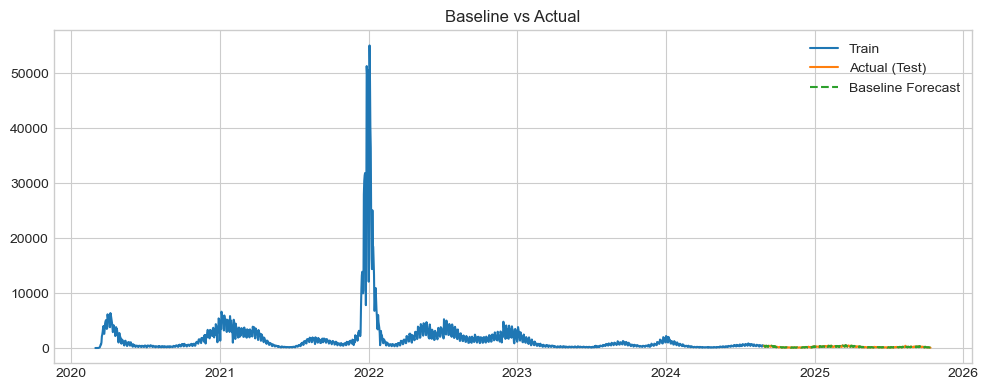

In [7]:
baseline_pred = test.shift(1)
baseline_pred.iloc[0] = train.iloc[-1]  # use last train value for first prediction
rmse_baseline = mean_squared_error(test, baseline_pred, squared=False)

print(f"Baseline RMSE: {rmse_baseline:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(baseline_pred, label="Baseline Forecast", color="#2ca02c", linestyle="--")
plt.title("Baseline vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

### Step 6:  Create an ARIMA (1,1,1) model:  Fit on TRAIN, forecast into TEST, calculate RMSE
- Plot the visual of the model

ARIMA(1,1,1) RMSE: 261.128


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


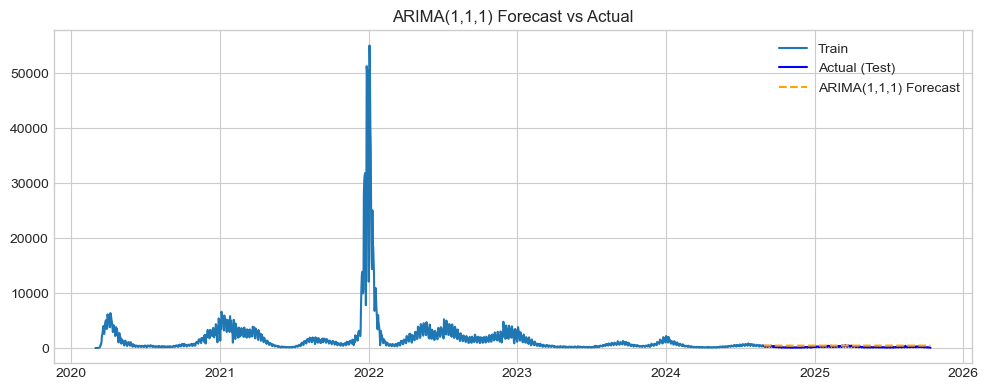

In [9]:
# fit the model on TRAIN
model_111 = ARIMA(train, order=(1,1,1))
fit_111 = model_111.fit()

# forecast into TEST window
pred_111 = fit_111.predict(start=test.index[0], end=test.index[-1])

# RMSE
rmse_111 = mean_squared_error(test, pred_111, squared=False)
print(f"ARIMA(1,1,1) RMSE: {rmse_111:.3f}")

# Plot
plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="blue")
plt.plot(pred_111, label="ARIMA(1,1,1) Forecast", color="orange", linestyle="--")
plt.title("ARIMA(1,1,1) Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


### Step 7:  Create an ARIMA(2,1,1):  Fit on TRAIN, forecast into TEST, calculate RMSE
- Plot the visual of the model

ARIMA(2,1,1) RMSE: 220.662


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


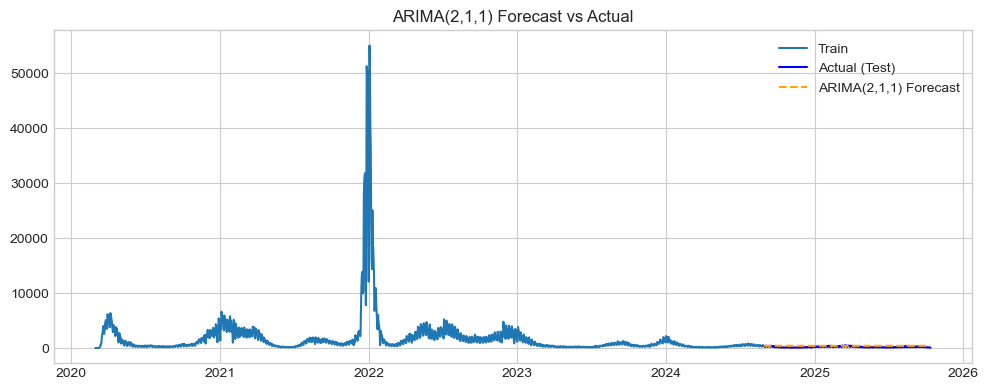

In [10]:
model_211 = ARIMA(train, order=(2,1,1))
fit_211 = model_211.fit()

pred_211 = fit_211.predict(start=test.index[0], end=test.index[-1])
rmse_211 = mean_squared_error(test, pred_211, squared=False)
print(f"ARIMA(2,1,1) RMSE: {rmse_211:.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="blue")
plt.plot(pred_211, label="ARIMA(2,1,1) Forecast", color="orange", linestyle="--")
plt.title("ARIMA(2,1,1) Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


## Reflection (We Share)
- Which ARIMA order performed best vs. baseline? By how much (%) did it reduce RMSE?
    - In my results, the baseline shift model performed the best with an RMSE of about 63. Both ARIMA models performed worse: ARIMA(1,1,1) had an RMSE around 261, and ARIMA(2,1,1) had an RMSE around 220. That means the baseline actually outperformed ARIMA by a large margin, reducing error by over 70–75% compared to the ARIMA models.
- If neither ARIMA beat baseline, what’s your next step (different d, seasonal naïve, SARIMA, widen training window, handle outliers)?
    - If I wanted to improve forecast accuracy, I could try a seasonal model (SARIMA), adjust p/d/q, remove extreme pandemic outliers, or train the model only on the quieter post-2022 data to avoid being influenced by the huge spikes.